# <span style="color:turquoise">**Análisis y preprocesamiento de los datos**</span>

## **Hardware**

**PC** Lenovo Idealpad Gaming3

**Procesador** AMD Ryzen 5 5600H with Radeon Graphics 3.3 GHz

	Velocidad de base:	3,30 GHz
	Sockets:	1
	Núcleos:	6
	Procesadores lógicos:	12
	Virtualización:	Habilitado
	Caché L1:	384 kB
	Caché L2:	3,0 MB
	Caché L3:	16,0 MB

**Gráficos dedicados** NVIDIA GeForce RTX 3050 Laptop 

	Versión del controlador:	31.0.15.5176
	Fecha del controlador:	01/03/2024
	Versión de DirectX:	12 (FL 12.1)
	Memoria de GPU dedicada	4,0 GB
	Memoria de GPU compartida	7,7 GB
	Memoria de GPU	11,7 GB
	
**RAM** 16 GB SODIMM DDR4 

	Velocidad:	3200 MHz
	Ranuras usadas:	2 de 2
	Factor de forma:	SODIMM

**Memoria estado sólido** SSD 512 GB 2210 NVMe PCIe Gen3 x4  Micron MTFDHBA512QFD

**Google Colab** 
	12.7 GB RAM, 15 GB RAM GPU Tesla T4, SSD 78.2 GB

In [1]:
!nvidia-smi

Sun Jul  6 21:06:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0              6W /   60W |     321MiB /   4096MiB |     32%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Dependencias**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import collections, random, shutil, cv2, os, json, subprocess
import xml.etree.ElementTree as ET
from pathlib import Path

from lib.preprocesamiento_lib import yolo_format

## **Etiquetado de datos**

Se han etiquetado 60 imágenes del conjunto de test que contanba con 1273 instancias y pasa a tener X instancias.

In [3]:
# !git clone https://github.com/tzutalin/labelImg.git

# Instalar dependencias de labelImg
!pip install PyQt5 lxml

# Cambiar al directorio y ejecutar
original_dir = os.getcwd()
os.chdir(".\labelImg")

try:
    # Ejecutar labelImg
    subprocess.run(["python", "labelImg.py"])
finally:
    # Volver al directorio original
    os.chdir(original_dir)

## **Datasets**

In [4]:
base_path_test = r"..\\03.Datasets\\04.Images_for_training_test\\02a.Test_Labelling"
base_path_train = r"..\\03.Datasets\\04.Images_for_training_test\\01a.Training_Labelling"

def draw_visual_boxes(base_path):

    dimension_count = collections.defaultdict(int)

    img_path = os.path.join(base_path, "original_images")
    xml_path = os.path.join(base_path, "annotations")  
    output_path = os.path.join(base_path, "visual_boxes")
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_files = [f for f in os.listdir(img_path) if f.endswith('.jpg')]

    for image_file in image_files:
        image_number = image_file.replace('.jpg', '')
        img = cv2.imread(os.path.join(img_path, image_file))
        height, width = img.shape[:2]

        dimension_count[(width, height)] += 1

        xml_file = os.path.join(xml_path, f"{image_number}.xml")
        if os.path.exists(xml_file):
            try:
                # Parsear XML
                tree = ET.parse(xml_file)
                root = tree.getroot()
                
                for obj in root.findall('object'):
                    bndbox = obj.find('bndbox')
                    if bndbox is not None:
                        xmin = int(float(bndbox.find('xmin').text))
                        ymin = int(float(bndbox.find('ymin').text))
                        xmax = int(float(bndbox.find('xmax').text))
                        ymax = int(float(bndbox.find('ymax').text))
                        
                        xmin = max(0, min(xmin, width))
                        ymin = max(0, min(ymin, height))
                        xmax = max(0, min(xmax, width))
                        ymax = max(0, min(ymax, height))
                        
                        # Dibujar bounding box
                        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

                # Guardar imagen resultante
                output_file = os.path.join(output_path, f"bbox_{image_file}")
                cv2.imwrite(output_file, img)
                
            except ET.ParseError as e:
                print(f"Error al parsear XML {xml_file}: {e}")
            except Exception as e:
                print(f"Error procesando {xml_file}: {e}")
        else:
            print(f"No se encontró XML para: {image_file}")

    total_images = sum(dimension_count.values())
    for dim, count in dimension_count.items():
        print(f"Dimension {dim}: {count} imágenes")
    print(f"Número total de imágenes: {total_images}")
    
print("\nResumen dimensiones train: ")
draw_visual_boxes(base_path_train)
print("\nResumen dimensiones test: ")
draw_visual_boxes(base_path_test)


Resumen dimensiones train: 
Dimension (1280, 1024): 356 imágenes
Dimension (768, 616): 17 imágenes
Número total de imágenes: 373

Resumen dimensiones test: 
Dimension (1280, 1024): 87 imágenes
Dimension (768, 616): 7 imágenes
Número total de imágenes: 94


## **Preprocesamiento de datos**

### YOLO format

In [6]:
def plot_distribution(values, labels, title, xlabel, ylabel, colors = None, figsize=(10,6)):
    """
    Gráfico de barras personalizado.

    Parameters:
    values : list
        Valores numéricos para cada barra.
    labels : list
        Etiquetas para cada barra.
    title : str
        Título del gráfico.
    xlabel : str
        Nombre del eje X.
    ylabel : str
        Nombre del eje Y.
    colors : list or None
        Lista de colores para las barras.
    figsize : tuple
        Tamaño de la figura.
    """
    if colors is None:
        colors = ['#1f77b4', "#00F7FF", "#a7f62f"]
    plt.figure(figsize=figsize)
    bars = plt.bar(labels, values, color=colors, alpha=0.6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{int(height)}',
            ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

```plaintext
YOLO_Datasets/
├── train/
│   ├── images/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   └── labels/
│       ├── image1.txt
│       ├── image2.txt
│       └── ...
|
├── split/
|   ├── train/
│   │   ├── images/
|   |   |   ├── image1.jpg
│   │   |   ├── image2.jpg
│   │   |   └── ...
│   │   └── labels/
|   |       ├── image1.txt
│   │       ├── image2.txt
│   │       └── ...
│   │   
│   └── val/
│       ├── images/
|       |   ├── image1.jpg
│       |   ├── image2.jpg
│       |   └── ...
│       └── labels/
|           ├── image1.txt
│           ├── image2.txt
│           └── ...
│       
├── test/
│   ├── images/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   └── labels/
│       ├── image1.txt
│       ├── image2.txt
│       └── ...

In [4]:
train_input_image_folder = '..\\03.Datasets\\04.Images_for_training_test\\01.Training'
train_output_image_folder = '..\\03.Datasets\\YOLO_Datasets\\train\\images'
tain_input_xml_folder = '..\\03.Datasets\\04.Images_for_training_test\\01a.Training_Labelling\\annotations'
train_output_labels_folder = '..\\03.Datasets\\YOLO_Datasets\\train\\labels'

test_input_image_folder = '..\\03.Datasets\\04.Images_for_training_test\\02.Test'
test_output_image_folder = '..\\03.Datasets\\YOLO_Datasets\\test\\images'
test_input_xml_folder = '..\\03.Datasets\\04.Images_for_training_test\\02a.Test_Labelling\\annotations'
test_output_labels_folder = '..\\03.Datasets\\YOLO_Datasets\\test\\labels'

split_output_folder = "..\\03.Datasets\\YOLO_Datasets\\split"
SPLIT = 0.8

preprocess = yolo_format.CPreprocessing_YOLO()

os.makedirs(train_output_image_folder, exist_ok=True)
os.makedirs(train_output_labels_folder, exist_ok=True)
os.makedirs(test_output_image_folder, exist_ok=True)
os.makedirs(test_output_labels_folder, exist_ok=True)

empty_xml_imgs_train = preprocess.process_images(train_input_image_folder, tain_input_xml_folder, train_output_labels_folder)
empty_xml_imgs_test = preprocess.process_images(test_input_image_folder, test_input_xml_folder, test_output_labels_folder)

preprocess.copy_images(train_input_image_folder, train_output_image_folder, empty_xml_imgs_train)
preprocess.copy_images(test_input_image_folder, test_output_image_folder, empty_xml_imgs_test)

preprocess.split_dataset(train_output_image_folder, train_output_labels_folder, split_output_folder, SPLIT)

Tenemos 350 imágenes con etiquetas y 23 que no estan etiquetadas
Tenemos 88 imágenes con etiquetas y 6 que no estan etiquetadas
Directorio ..\03.Datasets\YOLO_Datasets\split eliminado y será recreado

Conjunto split de train: 280 imágenes
Conjunto split de val:  70 imágenes


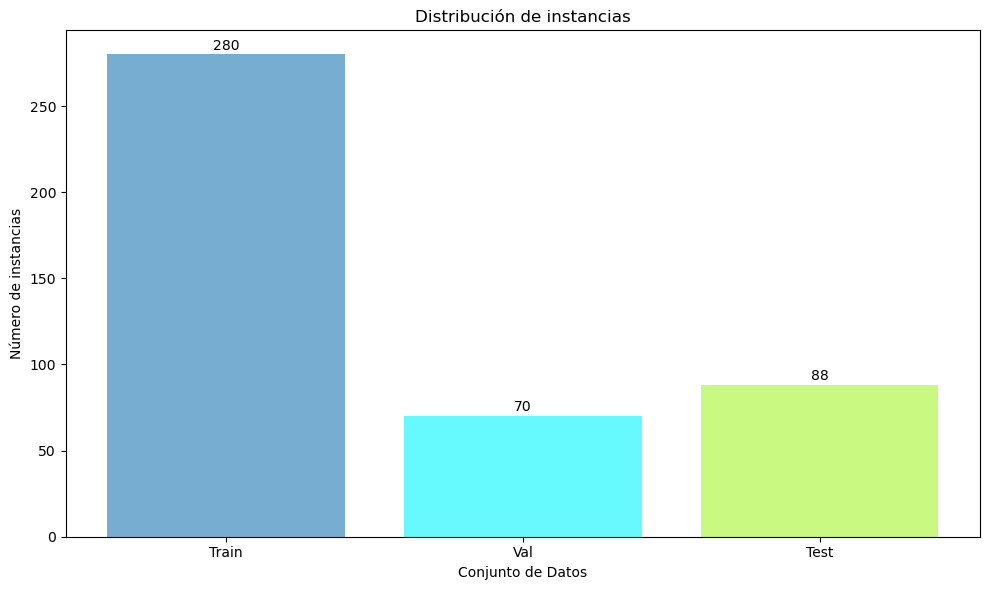

In [8]:
plot_distribution(
    values = [280, 70, 88],
    labels=['Train', 'Val', 'Test'],
    title='Distribución de instancias',
    xlabel='Conjunto de Datos',
    ylabel='Número de instancias'
)

Comprobamos que las etiquetas asociadas a las imagenes del conjunto split permanece invariante.

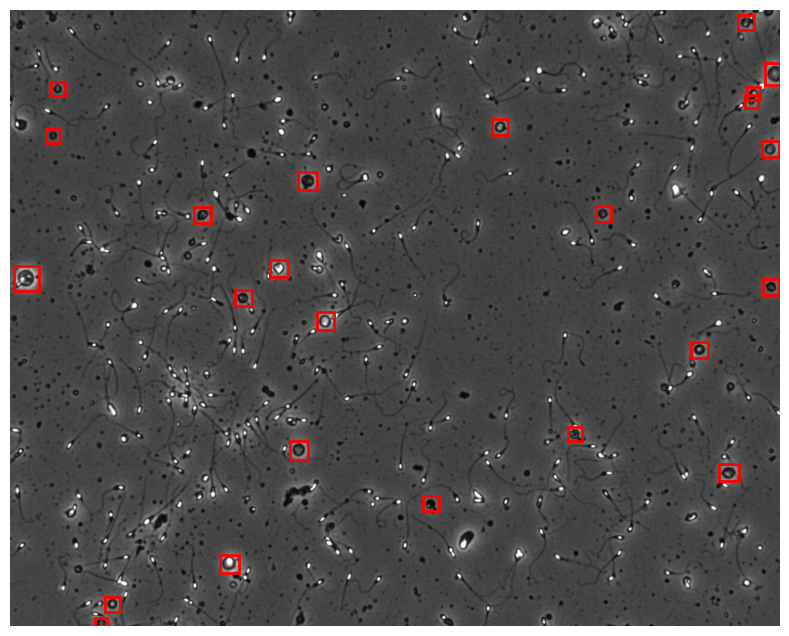

In [9]:
image_path = '../03.Datasets/YOLO_Datasets/test/images/7.jpg'
label_path = '../03.Datasets/YOLO_Datasets/test/labels/7.txt'

preprocess.plot_image_with_boxes(image_path, label_path)

### YOLO to COCO

In [10]:
class YoloToCoco:
    def __init__(self, classes):
        self.classes = classes
        self.categories = [{"id": i+1, "name": n} for i,n in enumerate(classes)]

    def convert_yolo_to_coco(self, img_dir, lbl_dir, out_json, dataset):
        """
        Convert annotations from YOLO format to COCO format.

        This method processes images and their corresponding YOLO format annotation
        files and converts them to a single COCO format JSON file. Each bounding box
        in YOLO format (class, x_center, y_center, width, height - normalized) is 
        converted to COCO format (x, y, width, height - in pixels).

        Parameters:
        -----------
        img_dir : str or Path
            Directory containing the image files (.jpg)
        lbl_dir : str or Path
            Directory containing the YOLO format annotation files (.txt)
        out_json : str or Path
            Path where the output COCO format JSON file will be saved
        """
        images, annots, ann_id = [], [], 1
        for img_id, fn in enumerate(sorted(os.listdir(img_dir)), 1):
            if not fn.endswith(".jpg"): continue
            path = os.path.join(img_dir, fn)
            h, w = cv2.imread(path).shape[:2]
            images.append({"id": img_id, "file_name": fn, "height": h, "width": w})
            txt = os.path.join(lbl_dir, fn.replace(".jpg", ".txt"))
            if not os.path.exists(txt): continue
            for L in open(txt):
                cls, xc,yc,bw,bh = map(float, L.split())
                cx,cy,bw,bh = xc*w, yc*h, bw*w, bh*h
                x0,y0 = cx-bw/2, cy-bh/2
                annots.append({
                    "id": ann_id, "image_id": img_id,
                    "category_id": int(cls)+1,
                    "bbox": [round(x0,2), round(y0,2), round(bw,2), round(bh,2)],
                    "area": round(bw*bh,2), "iscrowd": 0
                })
                ann_id += 1

        coco = {"images": images, "annotations": annots, "categories": self.categories}
        Path(out_json).parent.mkdir(exist_ok=True, parents=True)
        with open(out_json, "w", encoding="utf-8") as f:
            json.dump(coco, f, indent=2, ensure_ascii=False)
        print(f"→ {dataset}: {len(images)} imgs, {len(annots)} bbox")
        
        if (dataset == "train"):
            num_instances = len(annots)
        elif (dataset == "val"):
            num_instances = len(annots)
        elif (dataset == "test"):
            num_instances = len(annots)

        return num_instances

In [11]:
CLASSES = ["defect"]  
BASE    = Path(r"..\\03.Datasets\\YOLO_Datasets")
COCO    = Path(r"..\\03.Datasets\\COCO_Datasets")

trasform = YoloToCoco(CLASSES)
num_train_instances = trasform.convert_yolo_to_coco(BASE/"split"/"train"/"images", BASE/"split"/"train"/"labels", COCO/"train.json", "train")
num_val_instances   = trasform.convert_yolo_to_coco(BASE/"split"/"val"/"images", BASE/"split"/"val"/"labels", COCO/"val.json", "val")
num_test_instances  = trasform.convert_yolo_to_coco(BASE/"test"/"images", BASE/"test"/"labels",COCO/"test.json", "test")

→ train: 280 imgs, 3921 bbox
→ val: 70 imgs, 891 bbox
→ test: 88 imgs, 1412 bbox


```plaintext
03.Datasets/
├── YOLO_Datasets/
│   ├── split/
│   │   ├── train/
│   │   │   ├── images/
│   │   │   └── labels/
│   │   └── val/
│   │       ├── images/
│   │       └── labels/
│   └── test/
│       ├── images/
│       └── labels/
└── COCO_Datasets/  
    ├── train.json
    ├── val.json
    └── test.json

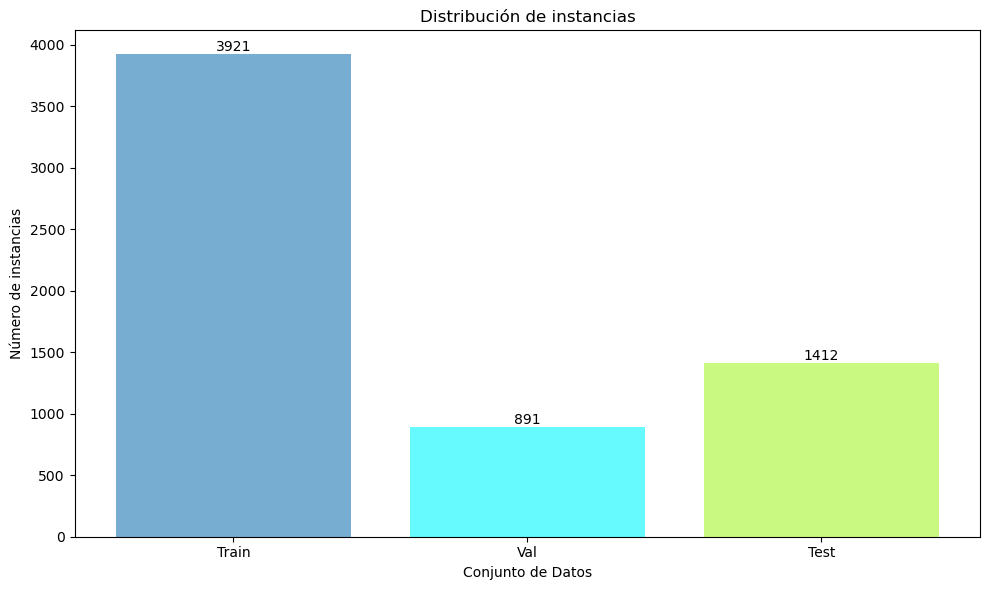

In [12]:
plot_distribution(
    values = [num_train_instances, num_val_instances, num_test_instances],
    labels=['Train', 'Val', 'Test'],
    title='Distribución de instancias',
    xlabel='Conjunto de Datos',
    ylabel='Número de instancias'
)